In [2]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [3]:
import spacy
nlp = spacy.load('en_core_web_lg')

doc = nlp("Nagal won the first set.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


In [4]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################
  
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

        # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                modifier = prv_tok_text + " "+ tok.text

        ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

        ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text

          ## chunk 5  
          # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
        #############################################################

    return [ent1.strip(), ent2.strip()]

In [5]:
get_entities('Nagal won the first set.')

['Nagal', 'first  set']

In [6]:

def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = spacy.matcher.Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [7]:
get_relation("Nagal won the first set.")

'won'

In [8]:
import pandas as pd
from tqdm import tqdm

df = pd.read_csv('Download/Cleaned Data/NoSleep.csv')

In [9]:
sample = ''.join([''.join(i) for i in df.sample()['selftext']])

In [10]:
doc = nlp(sample)
entity_pairs = []

for i in tqdm([sent for sent in doc.sents]):
    entity_pairs.append(get_entities(str(i)))

100%|██████████| 82/82 [00:00<00:00, 219.74it/s]


In [11]:
relations = [get_relation(str(i)) for i in tqdm([sent for sent in doc.sents])]

100%|██████████| 82/82 [00:00<00:00, 223.86it/s]


In [12]:
pd.Series(relations).value_counts()[:50]

was              8
is               5
think            3
giving           2
are different    2
knew             2
Am               2
know             2
wish             2
made             1
called           1
care             1
mentioned        1
listen to        1
thought          1
lolling          1
downed           1
's more          1
decided          1
was weird        1
woke             1
had              1
blame            1
's other         1
have             1
loves            1
was in           1
looked           1
felt good        1
on               1
lying to         1
be afraid        1
come             1
DNA              1
is out           1
run              1
took             1
find             1
going            1
bared            1
do               1
resigned         1
hoped            1
searched         1
remembered       1
speaks           1
came             1
used             1
tried            1
happened         1
dtype: int64

In [13]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,first I,you,lying to
1,I,,hoped
2,rambling sob I,emotions,downed
3,I,,know
4,,least subreddit,on
...,...,...,...
77,What,,going
78,I,,Am
79,I,,Am
80,any,really situation,think


In [21]:
import networkx as nx
import matplotlib.pyplot as plt
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

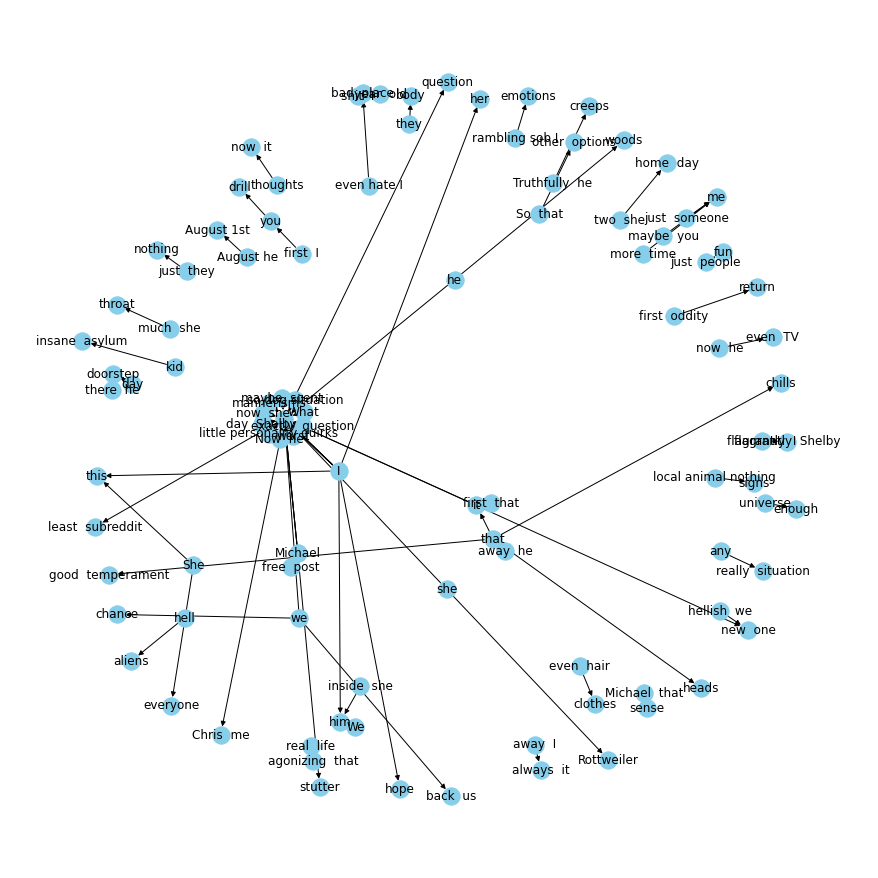

In [24]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

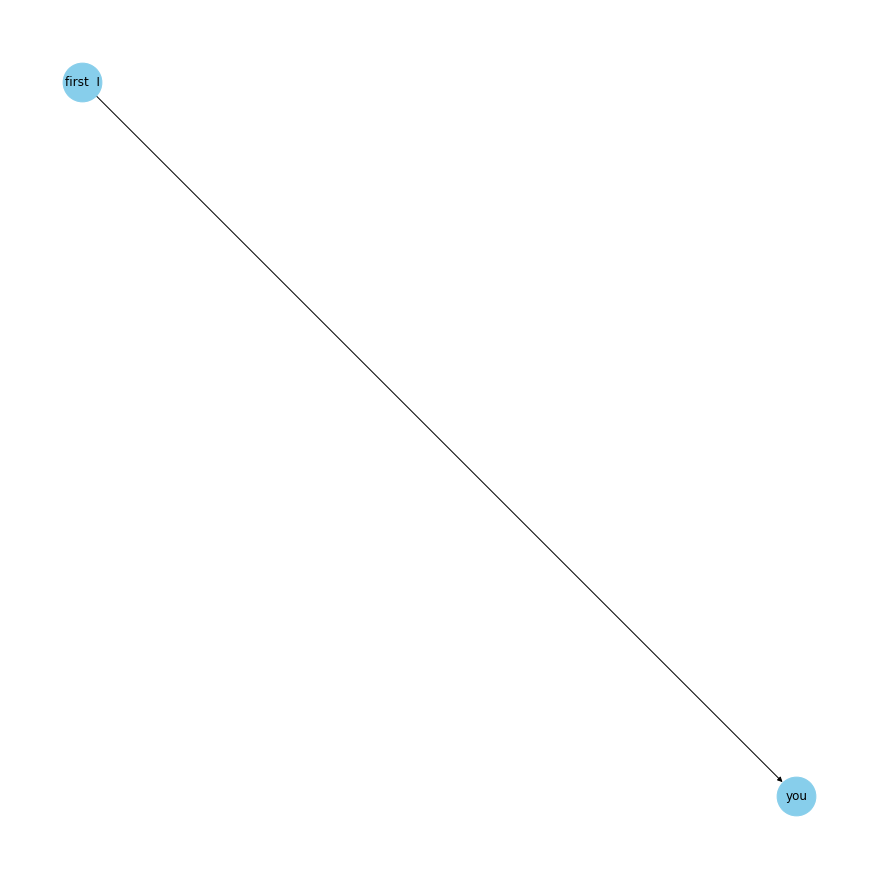

In [18]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="lying to"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

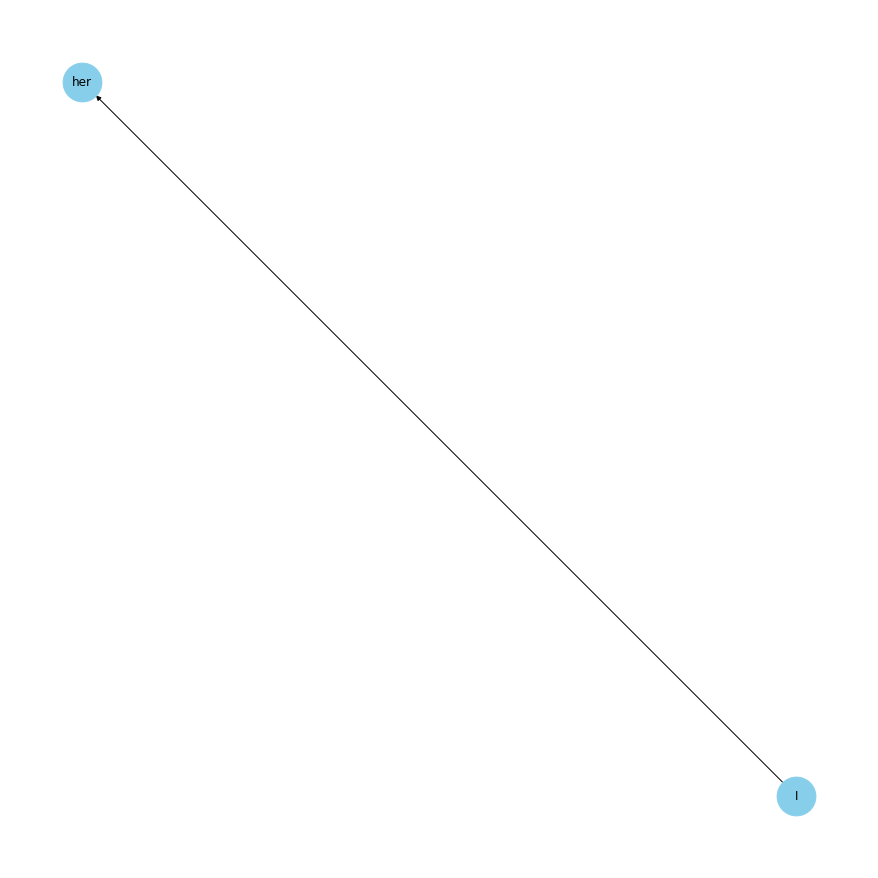

In [17]:
G=nx.from_pandas_edgelist(kg_df[kg_df['target']=="her"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()